# TRABAJO PRACTICO FINAL - PROCESAMIENTO DEL LENGUAJE NATURAL

**Tecnicatura Universitaria en Inteligencia Artificial**  
**Universidad Nacional de Rosario**

---

**Materia:** IA 4.2 - Procesamiento del Lenguaje Natural  
**Estudiante:** Sebastián Palacio  
**DNI:** 43491996
**Fecha de entrega:** 7 de diciembre de 2025

**Docentes:**
- Juan Pablo Manson
- Alan Geary
- Constantino Ferrucci

---

## Descripcion del Trabajo

Este notebook implementa un sistema completo de asistente virtual para una empresa de electrodomesticos utilizando:

### **Ejercicio 1: Sistema RAG Multimodal**
- **Base Vectorial:** ChromaDB con 3,050 documentos (FAQs + manuales)
- **Base Tabular:** Pandas/SQLite con 300 productos, 10,000 ventas
- **Base de Grafos:** Neo4j con 410 nodos, 768 relaciones
- **Búsqueda Híbrida:** Vector + BM25 + Reranking para máxima precisión

### **Ejercicio 2: Agente ReAct con IA Real**
- **Cerebro Inteligente:** Groq API (Llama-3.3-70b-versatile)
- **4 Herramientas Dinámicas:**
  - `doc_search`: Búsqueda semántica en documentos
  - `table_search`: **SQL dinámico generado por LLM**
  - `graph_search`: **Cypher dinámico generado por LLM**  
  - `analytics`: **Análisis completo generado por LLM** (SQL + gráficos + descripción)
- **Memoria Conversacional:** Detección automática de continuidad

---

# **Parte 1**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

!unzip "/content/drive/MyDrive/NLP/todo.zip" -d /content/

Se han truncado las últimas 5000 líneas del flujo de salida.
  inflating: /content/resenas_usuarios/resena_R02810.txt  
  inflating: /content/resenas_usuarios/resena_R04844.txt  
  inflating: /content/resenas_usuarios/resena_R03827.txt  
  inflating: /content/resenas_usuarios/resena_R02387.txt  
  inflating: /content/resenas_usuarios/resena_R04787.txt  
  inflating: /content/resenas_usuarios/resena_R02558.txt  
  inflating: /content/resenas_usuarios/resena_R03381.txt  
  inflating: /content/resenas_usuarios/resena_R02048.txt  
  inflating: /content/resenas_usuarios/resena_R04816.txt  
  inflating: /content/resenas_usuarios/resena_R03409.txt  
  inflating: /content/resenas_usuarios/resena_R03156.txt  
  inflating: /content/resenas_usuarios/resena_R04748.txt  
  inflating: /content/resenas_usuarios/resena_R02663.txt  
  inflating: /content/resenas_usuarios/resena_R03348.txt  
  inflating: /content/resenas_usuarios/resena_R04040.txt  
  inflating: /content/resenas_usuarios/resena_R02545.t

## **Distribución por tipo de base de datos**

1. BASE DE DATOS VECTORIAL (ChromaDB/FAISS)

Contenido:
  - FAQs (3,000 preguntas-respuestas)
  - Manuales de productos (50 manuales)
  - [OPCIONAL] Reseñas de usuarios (5,015 reseñas)

Justificación:
  - Información textual no estructurada
  - Ideal para búsqueda semántica
  - Responde preguntas como:
    * "¿Cómo uso mi licuadora para hacer smoothies?"
    * "¿Qué voltaje requiere el rallador digital eléctrico?"
    * "¿Qué opinan los usuarios de esta cafetera?"


2. BASE DE DATOS TABULAR (Pandas/SQL)

Contenido:
  - productos.csv (precio, stock, specs técnicas)
  - inventario_sucursales.csv (stock por sucursal)
  - ventas_historicas.csv (para analytics_tool en Ejercicio 2)

Justificación:
  - Datos estructurados con campos numéricos y categóricos
  - Requiere filtros y comparaciones exactas
  - Responde preguntas como:
    * "¿Cuáles son las licuadoras de menos de $200?"
    * "¿Qué productos están en la categoría Cocina?"
    * "Quiero una licuadora con buenas reseñas"


3. BASE DE DATOS DE GRAFOS (Neo4j/NetworkX)

Contenido (Relaciones):
  - Producto -> Categoría -> Subcategoría
  - Producto -> Vendedor (desde ventas_historicas)
  - Vendedor -> Sucursal
  - Producto -> Tickets de soporte
  - Cliente -> Provincia -> Compras

Justificación:
  - Datos interconectados con múltiples relaciones
  - Consultas de tipo "caminos" y "conexiones"
  - Responde preguntas como:
    * "¿Qué productos están relacionados con Cocina?"
    * "¿Qué vendedores venden productos de la marca X?"
    * "¿Qué productos tienen más tickets de soporte?"

### Justificación de Framework

In [2]:
framework_analysis = """
DECISIÓN: Uso de LlamaIndex en lugar de Langchain

CONTEXTO DEL ENUNCIADO:
El TP especifica: "Utilizar Langchain para implementar un agente basado
en el paradigma ReAct"

DECISIÓN TOMADA:
Se utilizó LlamaIndex para todo el proyecto (Ejercicio 1 y 2)

JUSTIFICACIÓN TÉCNICA:

COMPATIBILIDAD CON MATERIAL DE CLASE:
   - El material TUIA_NLP_Unidad_7.ipynb usa LlamaIndex y me guié principalmente por los contenidos de clase
   - Los ejemplos de ReAct en clase están en LlamaIndex
   - Metodología enseñada: LlamaIndex para RAG + Agentes

"""

## **Preparación de dependencias y librerías**

In [3]:
%%capture
!pip install llama_index==0.12.39 llama-index-embeddings-huggingface==0.5.4 sentence-transformers==4.1.0
!pip install rank_bm25 unidecode nltk
!pip install neo4j networkx matplotlib
!pip install faiss-cpu pandas
!pip install -q chromadb langchain langchain-community sentence-transformers rank-bm25
!pip install google-generativeai
!pip install langchain-groq langchain-community langchain-core langchain

In [4]:
import json
import os
import pandas as pd
import numpy as np
from typing import List, Dict, Any
import time

from llama_index.embeddings.huggingface import HuggingFaceEmbedding
from llama_index.core import VectorStoreIndex, Document as LlamaDocument, Settings
from llama_index.core.schema import TextNode, NodeWithScore
from llama_index.core.tools import FunctionTool
from langchain_community.utilities import SQLDatabase
from langchain_groq import ChatGroq
from langchain_core.prompts import ChatPromptTemplate, PromptTemplate
from langchain_core.messages import HumanMessage, AIMessage, SystemMessage

import google.generativeai as genai

from sentence_transformers import CrossEncoder, SentenceTransformer

from rank_bm25 import BM25Okapi
import nltk
from nltk.tokenize import word_tokenize
from unidecode import unidecode
import re


from neo4j import GraphDatabase
import networkx as nx
import matplotlib.pyplot as plt

import sqlite3
from sqlalchemy import create_engine

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns

ruta_base = '/content/'


/usr/local/lib/python3.12/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'validate_default' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'validate_default' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/jax/_src/cloud_tpu_init.py:86: UserWarning: Transparent hugepages are not enabled. TPU runtime startup and shutdown time should be significantly improved on TPU v5e and newer. If not already set, you may need to enable transparent hugepages in your VM image (sudo sh -c "echo always > /sys/kernel/mm/transparent_hugepage/enabled")
  warnings.warn(
/usr/local/lib/python3.12/dist-pa

### Configuración del modelo de embeddings

In [5]:
print('Cargando modelo de embeddings para español...')

model_name = "sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2"

#Configurar globalmente en LlamaIndex
Settings.embed_model = HuggingFaceEmbedding(model_name=model_name)

print(f"Modelo configurado: {model_name}")

#Prueba
test_embedding = Settings.embed_model.get_text_embedding("¿Cómo uso mi licuadora?")
print(f"Dimensión del embedding: {len(test_embedding)}")

Cargando modelo de embeddings para español...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/645 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/471M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/480 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.08M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Modelo configurado: sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2
Dimensión del embedding: 384


### CONFIGURAR GROQ API

In [ ]:
groq_llm = None

def setup_groq():
    """Configuración interactiva de Groq API"""
    global groq_llm
    if groq_llm is None:
        api_key = input("API Key de Groq (o Enter para usar fallback): ").strip()
        if api_key:
            groq_llm = ChatGroq(
                model='llama-3.3-70b-versatile',
                api_key=api_key,
                verbose=True,
            )
            # Test de conexión
            try:
                test = groq_llm.invoke('Hola').content
                print(f"Groq configurado exitosamente")
                return groq_llm
            except Exception as e:
                print(f"Error configurando Groq: {e}")
                groq_llm = None
                return None
        else:
            print("Sin API key - usando fallback")
            groq_llm = None
            return None
    return groq_llm

# Inicializar (va a pedir la key)
setup_groq()
print("Test Groq:", groq_llm.invoke('Hola').content)

### Carga de datos

In [7]:
#FAQs
print("\n1. Cargando FAQs...")
with open(ruta_base + 'faqs.json', 'r', encoding='utf-8') as f:
    faqs = json.load(f)
print(f"   ✓ {len(faqs)} FAQs cargados")

#Manuales
print("\n2. Cargando manuales...")
manuales_dir = ruta_base + 'manuales_productos/'
manuales = []

for archivo in os.listdir(manuales_dir):
    if archivo.endswith('.md'):
        with open(os.path.join(manuales_dir, archivo), 'r', encoding='utf-8') as f:
            contenido = f.read()

        id_producto = archivo.split('_')[1]
        manuales.append({
            'id_producto': id_producto,
            'nombre_archivo': archivo,
            'contenido': contenido
        })

print(f"   ✓ {len(manuales)} manuales cargados")

#CSVs para base tabular
print("\n3. Cargando datos tabulares...")
df_productos = pd.read_csv(ruta_base + 'productos.csv')
df_ventas = pd.read_csv(ruta_base + 'ventas_historicas.csv')
df_inventario = pd.read_csv(ruta_base + 'inventario_sucursales.csv')

print(f"   ✓ Productos: {len(df_productos)} registros")
print(f"   ✓ Ventas: {len(df_ventas)} registros")
print(f"   ✓ Inventario: {len(df_inventario)} registros")




1. Cargando FAQs...
   ✓ 3000 FAQs cargados

2. Cargando manuales...
   ✓ 50 manuales cargados

3. Cargando datos tabulares...
   ✓ Productos: 300 registros
   ✓ Ventas: 10000 registros
   ✓ Inventario: 4100 registros


In [8]:
import json
from llama_index.core import SimpleDirectoryReader

#Cargar documentos
documents = []
with open('/content/faqs.json', 'r', encoding='utf-8') as f:
    faqs = json.load(f)
for faq in faqs:
    text = f"{faq['pregunta']} {faq['respuesta']}"
    documents.append(LlamaDocument(text=text))


manual_docs = SimpleDirectoryReader('/content/manuales_productos').load_data()
documents.extend(manual_docs)


resena_docs = SimpleDirectoryReader('/content/resenas_usuarios').load_data()
documents.extend(resena_docs)

## **Creación de las bases de datos**

### Base de datos 1: vectorial (ChromaDB con LlamaIndex)

In [9]:
print("\n3. Creando índice vectorial...")
vector_index = VectorStoreIndex.from_documents(
    documents,
    show_progress=True
)

print("\n Índice vectorial creado exitosamente")

vector_retriever = vector_index.as_retriever(similarity_top_k=5)
print("Retriever configurado (top_k=5)")


3. Creando índice vectorial...


Parsing nodes:   0%|          | 0/8065 [00:00<?, ?it/s]

Generating embeddings:   0%|          | 0/2048 [00:00<?, ?it/s]

Generating embeddings:   0%|          | 0/2048 [00:00<?, ?it/s]

Generating embeddings:   0%|          | 0/2048 [00:00<?, ?it/s]

Generating embeddings:   0%|          | 0/2023 [00:00<?, ?it/s]


 Índice vectorial creado exitosamente
Retriever configurado (top_k=5)


### Base de datos 2: Tabular

In [10]:
#Extraer metadata de los dataframes (para el LLM)
def extract_dataframe_metadata(df, df_name):
    """Extrae información relevante del DataFrame para el LLM"""
    metadata = {
        'nombre': df_name,
        'shape': df.shape,
        'columnas': list(df.columns),
        'tipos': df.dtypes.to_dict(),
        'info_columnas': {}
    }

    for col in df.columns:
        col_info = {}

        if df[col].dtype in ['object', 'category']:
            #Campos categóricos
            valores_unicos = df[col].dropna().unique()
            col_info['tipo'] = 'categórico'
            col_info['valores_unicos'] = list(valores_unicos[:20])  # Máximo 20
            col_info['n_unicos'] = len(valores_unicos)
        elif df[col].dtype in ['int64', 'float64']:
            #Campos numéricos
            col_info['tipo'] = 'numérico'
            col_info['min'] = float(df[col].min()) if not pd.isna(df[col].min()) else None
            col_info['max'] = float(df[col].max()) if not pd.isna(df[col].max()) else None
            col_info['mean'] = float(df[col].mean()) if not pd.isna(df[col].mean()) else None
        else:
            col_info['tipo'] = str(df[col].dtype)

        metadata['info_columnas'][col] = col_info

    return metadata

#Extraer metadata
metadata_productos = extract_dataframe_metadata(df_productos, 'productos')
metadata_ventas = extract_dataframe_metadata(df_ventas, 'ventas_historicas')
metadata_inventario = extract_dataframe_metadata(df_inventario, 'inventario_sucursales')

#Mostrar ejemplo de metadata
print("\n   Ejemplo - Metadata de productos:")
print(f"   - Shape: {metadata_productos['shape']}")
print(f"   - Columnas: {metadata_productos['columnas'][:5]}...")
print(f"   - Categorías únicas: {metadata_productos['info_columnas']['categoria']}")


   Ejemplo - Metadata de productos:
   - Shape: (300, 14)
   - Columnas: ['id_producto', 'nombre', 'categoria', 'subcategoria', 'marca']...
   - Categorías únicas: {'tipo': 'categórico', 'valores_unicos': ['Cocina', 'Climatización', 'Lavado', 'Audio y Video'], 'n_unicos': 4}


In [11]:
print("CREANDO BASE DE DATOS VECTORIAL")
documents = []

#Convertir FAQs a documentos
print("\n1. Procesando FAQs...")
for faq in faqs:
    texto = f"Pregunta: {faq['pregunta']}\nRespuesta: {faq['respuesta']}"

    #Crear documento de LlamaIndex con metadata
    doc = LlamaDocument(
        text=texto,
        metadata={
            'id_faq': faq['id_faq'],
            'id_producto': faq['id_producto'],
            'nombre_producto': faq['nombre_producto'],
            'categoria': faq['categoria'],
            'tipo': 'faq'
        }
    )
    documents.append(doc)

print(f"    {len(faqs)} FAQs convertidos a documentos")

#Convertir Manuales a documentos
print("\n2. Procesando manuales...")
for manual in manuales:
    doc = LlamaDocument(
        text=manual['contenido'],
        metadata={
            'id_producto': manual['id_producto'],
            'nombre_archivo': manual['nombre_archivo'],
            'tipo': 'manual'
        }
    )
    documents.append(doc)

print(f"    {len(manuales)} manuales convertidos a documentos")

print(f"\n Total documentos para indexar: {len(documents)}")

CREANDO BASE DE DATOS VECTORIAL

1. Procesando FAQs...
    3000 FAQs convertidos a documentos

2. Procesando manuales...
    50 manuales convertidos a documentos

 Total documentos para indexar: 3050


In [12]:
#Crear string de información para el LLM
def create_metadata_string(metadata):
    """Convierte metadata en string legible para el LLM"""
    lines = []
    lines.append(f"DataFrame: {metadata['nombre']}")
    lines.append(f"Shape: {metadata['shape'][0]} filas, {metadata['shape'][1]} columnas")
    lines.append(f"Columnas: {', '.join(metadata['columnas'])}")
    lines.append("\nInformación de columnas:")

    for col, info in metadata['info_columnas'].items():
        if info['tipo'] == 'categórico':
            valores = info['valores_unicos'][:10]
            lines.append(f"  - {col}: categórico, valores ejemplo: {valores}")
        elif info['tipo'] == 'numérico':
            lines.append(f"  - {col}: numérico, rango [{info['min']}, {info['max']}]")

    return "\n".join(lines)

info_productos = create_metadata_string(metadata_productos)
info_ventas = create_metadata_string(metadata_ventas)
info_inventario = create_metadata_string(metadata_inventario)

### Base de datos 3: Grafos (Neo4j local)


In [13]:
%%capture
!apt-get install wget -y
!wget -O - https://debian.neo4j.com/neotechnology.gpg.key | apt-key add -
!echo 'deb https://debian.neo4j.com stable latest' | tee -a /etc/apt/sources.list.d/neo4j.list
!apt-get update
!apt-get install neo4j -y

In [14]:
#Quitar autenticación
!sed -i 's/#dbms.security.auth_enabled=false/dbms.security.auth_enabled=false/' /etc/neo4j/neo4j.conf
!service neo4j start
time.sleep(3)

uri = "neo4j://localhost:7687"
driver = GraphDatabase.driver(uri)
print("Neo4j iniciado y conectado")

#Verifico si está vacío
with driver.session() as session:
    result = session.run("MATCH (n) RETURN count(n) as total")
    total = result.single()["total"]
    print(f"Nodos actuales: {total}")

#Poblar si está vacío
if total == 0:

    relaciones = []

    for _, row in df_productos.iterrows():
        relaciones.append({
            'source': row['id_producto'], 'source_type': 'Producto',
            'relation': 'PERTENECE_A',
            'target': row['categoria'], 'target_type': 'Categoria'
        })
        relaciones.append({
            'source': row['categoria'], 'source_type': 'Categoria',
            'relation': 'TIENE_SUBCATEGORIA',
            'target': row['subcategoria'], 'target_type': 'Subcategoria'
        })
        relaciones.append({
            'source': row['id_producto'], 'source_type': 'Producto',
            'relation': 'ES_DE_MARCA',
            'target': row['marca'], 'target_type': 'Marca'
        })

    for _, row in df_ventas.head(100).iterrows():
        relaciones.append({
            'source': row['id_producto'], 'source_type': 'Producto',
            'relation': 'VENDIDO_POR',
            'target': row['id_vendedor'], 'target_type': 'Vendedor'
        })
        relaciones.append({
            'source': row['id_vendedor'], 'source_type': 'Vendedor',
            'relation': 'TRABAJA_EN',
            'target': row['sucursal'], 'target_type': 'Sucursal'
        })

    df_relaciones = pd.DataFrame(relaciones).drop_duplicates()
    print(f"Total relaciones: {len(df_relaciones)}")

    #Funciones para Neo4j
    def clear_database(tx):
        tx.run("MATCH (n) DETACH DELETE n")

    def create_schema(tx):
        tx.run("CREATE CONSTRAINT IF NOT EXISTS FOR (e:Entity) REQUIRE e.name IS UNIQUE")
        tx.run("CREATE INDEX IF NOT EXISTS FOR (e:Entity) ON (e.name)")

    def add_triple(tx, subject, relation, obj, subject_type, object_type):
        query = f"""
        MERGE (s:Entity:{subject_type} {{name: $subject}})
        MERGE (o:Entity:{object_type} {{name: $object}})
        MERGE (s)-[r:`{relation}`]->(o)
        """
        tx.run(query, subject=subject, object=obj)

    print("\nInsertando en Neo4j...")
    with driver.session() as session:
        session.execute_write(clear_database)
        session.execute_write(create_schema)

    with driver.session() as session:
        for i, row in df_relaciones.iterrows():
            session.execute_write(
                add_triple,
                row['source'], row['relation'], row['target'],
                row['source_type'], row['target_type']
            )
            if (i + 1) % 200 == 0:
                print(f"  Insertadas {i + 1}/{len(df_relaciones)}...")

    #Verifición
    with driver.session() as session:
        result = session.run("MATCH (n) RETURN count(n) as total")
        total = result.single()["total"]
        print(f"\n Neo4j poblado: {total} nodos")
else:
    print("Todo correcto, Neo4j ya tiene datos")

Directories in use:
home:         /var/lib/neo4j
config:       /etc/neo4j
logs:         /var/log/neo4j
plugins:      /var/lib/neo4j/plugins
import:       /var/lib/neo4j/import
data:         /var/lib/neo4j/data
certificates: /var/lib/neo4j/certificates
licenses:     /var/lib/neo4j/licenses
run:          /var/lib/neo4j/run
Starting Neo4j.
Started neo4j (pid:7456). It is available at http://localhost:7474
There may be a short delay until the server is ready.
Neo4j iniciado y conectado
Nodos actuales: 0
Total relaciones: 768

Insertando en Neo4j...
  Insertadas 400/768...
  Insertadas 600/768...

 Neo4j poblado: 410 nodos


## **Funciones de búsqueda**

### BÚSQUEDA HÍBRIDA: BM25 + Reranking

In [15]:
print("CONFIGURANDO BÚSQUEDA HÍBRIDA (BM25 + RERANKING)")

try:
    nltk.data.find('tokenizers/punkt')
except LookupError:
    nltk.download('punkt')

print("\n1. Implementando BM25Searcher...")

class BM25Searcher:
    """
    Implementación de búsqueda BM25 compatible con LlamaIndex (siguiendo clase)
    """
    def __init__(self, documents: List[LlamaDocument], language: str = 'spanish'):
        self.language = language
        self.documents = documents

        self.text_nodes = []
        for i, doc in enumerate(self.documents):
            text_node = TextNode(
                text=doc.text,
                metadata=doc.metadata if hasattr(doc, 'metadata') else {},
                id_=f"bm25_node_{i}"
            )
            self.text_nodes.append(text_node)

        self.corpus = [self._preprocess_text(node.text) for node in self.text_nodes]
        self.tokenized_corpus = [self._tokenize(text) for text in self.corpus]

        # Inicializa BM25
        self.bm25 = BM25Okapi(self.tokenized_corpus)

    def _preprocess_text(self, text: str) -> str:
        text = text.lower()
        text = unidecode(text)
        text = re.sub(r'[^a-zA-Z0-9\s]', ' ', text)
        text = re.sub(r'\s+', ' ', text).strip()
        return text

    def _tokenize(self, text: str) -> List[str]:
        return word_tokenize(text, language=self.language)

    def retrieve(self, query: str, top_k: int = 5) -> List[NodeWithScore]:
        processed_query = self._preprocess_text(query)
        tokenized_query = self._tokenize(processed_query)

        scores = self.bm25.get_scores(tokenized_query)
        top_indices = np.argsort(scores)[-top_k:][::-1]

        results = []
        for idx in top_indices:
            if scores[idx] > 0:
                node = NodeWithScore(
                    node=self.text_nodes[idx],
                    score=float(scores[idx])
                )
                results.append(node)

        return results

bm25_searcher = BM25Searcher(documents=documents)
print("    BM25Searcher creado")

class Reranker:
    """Reranker con CrossEncoder"""
    def __init__(self, model_name: str = 'cross-encoder/ms-marco-MiniLM-L-6-v2'):
        self.model = CrossEncoder(model_name)

    def rerank(self, query: str, nodes: List[NodeWithScore], top_k: int = None) -> List[NodeWithScore]:
        if not nodes:
            return nodes

        pairs = [(query, node.node.text) for node in nodes]

        scores = self.model.predict(pairs)

        scored_nodes = []
        for score, node in zip(scores, nodes):
            node.score = float(score)
            scored_nodes.append(node)
        scored_nodes.sort(key=lambda x: x.score, reverse=True)

        if top_k:
            scored_nodes = scored_nodes[:top_k]

        return scored_nodes

#Crear reranker
print("   Cargando modelo de reranking...")
reranker = Reranker()
print("    Reranker creado")

print("\n Búsqueda híbrida configurada correctamente")

CONFIGURANDO BÚSQUEDA HÍBRIDA (BM25 + RERANKING)


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.



1. Implementando BM25Searcher...
    BM25Searcher creado
   Cargando modelo de reranking...


config.json:   0%|          | 0.00/794 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/132 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

    Reranker creado

 Búsqueda híbrida configurada correctamente


### FUNCIÓN DE BÚSQUEDA HÍBRIDA (Vector + BM25 + Rerank)

In [16]:
def hybrid_search(query: str, top_k: int = 3, apply_rerank: bool = True):
    """
    Búsqueda híbrida que combina:
    1. Búsqueda vectorial (semántica)
    2. Búsqueda BM25 (palabras clave)
    3. Reranking (opcional)

    Args:
        query: Consulta del usuario
        top_k: Número de resultados finales
        apply_rerank: Si aplicar reranking o no

    Returns:
        Lista de NodeWithScore con los mejores resultados
    """
    #Búsqueda vectorial
    vector_nodes = vector_retriever.retrieve(query)

    #Búsqueda BM25
    bm25_nodes = bm25_searcher.retrieve(query, top_k=5)

    #Combinar resultados
    all_nodes = vector_nodes.copy()

    for bm25_node in bm25_nodes:
        is_duplicate = any(
            bm25_node.node.text == vector_node.node.text
            for vector_node in vector_nodes
        )
        if not is_duplicate:
            all_nodes.append(bm25_node)

    #Aplico reranking
    if apply_rerank:
        final_nodes = reranker.rerank(query, all_nodes, top_k=top_k)
    else:
        final_nodes = all_nodes[:top_k]

    return final_nodes

print("Función hybrid_search creada")

Función hybrid_search creada


## **Clasificador de Intenciones**

In [17]:
#3 intenciones posibles
INTENCIONES = ['vectorial', 'tabular', 'grafos']

print("\nIntenciones del sistema:")
print("  1. vectorial: Preguntas sobre uso, FAQs, manuales")
print("  2. tabular: Preguntas sobre precios, stock, especificaciones")
print("  3. grafos: Preguntas sobre relaciones (categorías, marcas, sucursales)")


Intenciones del sistema:
  1. vectorial: Preguntas sobre uso, FAQs, manuales
  2. tabular: Preguntas sobre precios, stock, especificaciones
  3. grafos: Preguntas sobre relaciones (categorías, marcas, sucursales)


### Creación de datos sintéticos para entrenar los clasificadores

In [18]:
datos_entrenamiento = []

#VECTORIAL - Preguntas sobre uso, FAQs, manuales
preguntas_vectorial = [
    "¿Cómo uso mi licuadora para hacer smoothies?",
    "¿Qué voltaje requiere el rallador digital?",
    "¿Cómo se limpia la freidora?",
    "¿Para qué sirve el botón pulse de la licuadora?",
    "¿Qué dice el manual sobre el mantenimiento?",
    "¿Cómo funciona la función de auto-limpieza?",
    "¿Qué especificaciones técnicas tiene este producto?",
    "¿Cómo instalo el aire acondicionado?",
    "¿Qué precauciones debo tener al usar la batidora?",
    "¿Cómo se programa el microondas?",
    "Necesito instrucciones de uso del producto",
    "¿Qué dice la garantía sobre este problema?",
    "¿Cómo se usa correctamente este electrodoméstico?",
    "¿Qué opinan los usuarios sobre esta cafetera?",
    "¿Tiene buenas reseñas este producto?",
    "¿Qué dicen los clientes sobre la calidad?",
    "¿Es recomendable según las opiniones?",
    "¿Cuál es la valoración promedio?",
    "¿Qué comentarios tienen los usuarios?",
    "¿Alguien probó este modelo?",
]

#TABULAR - Preguntas sobre precios, stock, especificaciones numéricas
preguntas_tabular = [
    "¿Cuáles son las licuadoras de menos de $200?",
    "¿Qué productos cuestan entre $100 y $500?",
    "¿Cuánto stock hay de este producto?",
    "¿Qué productos están en la categoría Cocina?",
    "Quiero una licuadora con buenas reseñas y precio bajo",
    "¿Cuál es el precio de la licuadora TechHome?",
    "¿Hay stock disponible en Buenos Aires?",
    "Necesito productos de color blanco",
    "¿Qué electrodomésticos tienen garantía de 36 meses?",
    "Busco productos con potencia mayor a 1000W",
    "¿Cuál es la licuadora más barata?",
    "¿Qué productos están en oferta?",
    "¿Cuántos productos hay en stock?",
    "Quiero ver todos los productos de la marca ChefMaster",
    "¿Qué heladeras tienen capacidad mayor a 300L?",
    "Necesito un producto con peso menor a 5kg",
    "¿Cuáles son los productos más vendidos?",
    "¿Qué productos tienen descuento?",
    "Busco electrodomésticos de 220V",
    "¿Cuál es el rango de precios de licuadoras?",
]

#GRAFOS - Preguntas sobre relaciones, categorías, conexiones
preguntas_grafos = [
    "¿Qué productos están relacionados con la categoría Cocina?",
    "¿Qué vendedores venden productos de la marca TechHome?",
    "¿En qué sucursales se vende este producto?",
    "¿Qué marcas tienen productos en Climatización?",
    "¿Qué subcategorías tiene la categoría Cocina?",
    "¿Qué productos vende el vendedor V0001?",
    "¿Qué relación hay entre esta marca y esa categoría?",
    "¿Qué sucursales venden productos ChefMaster?",
    "¿Qué categorías de productos hay?",
    "¿Qué marcas están disponibles?",
    "¿Qué vendedores trabajan en Córdoba?",
    "¿Qué productos están conectados con Audio y Video?",
    "¿Qué marcas tienen productos en múltiples categorías?",
    "¿Cuántas subcategorías tiene cada categoría?",
    "¿Qué vendedores venden productos de Preparación?",
    "¿En cuántas sucursales está disponible la marca KitchenPro?",
    "¿Qué productos comparten categoría con la licuadora?",
    "¿Qué conexiones hay entre vendedores y productos?",
    "¿Qué estructura tienen las categorías?",
    "¿Qué productos pertenecen a la subcategoría Refrigeración?",
]

#Creación del dataset
for pregunta in preguntas_vectorial:
    datos_entrenamiento.append({'texto': pregunta, 'intencion': 'vectorial'})

for pregunta in preguntas_tabular:
    datos_entrenamiento.append({'texto': pregunta, 'intencion': 'tabular'})

for pregunta in preguntas_grafos:
    datos_entrenamiento.append({'texto': pregunta, 'intencion': 'grafos'})

df_train = pd.DataFrame(datos_entrenamiento)

print(f"   Distribución:")
print(df_train['intencion'].value_counts())

   Distribución:
intencion
vectorial    20
tabular      20
grafos       20
Name: count, dtype: int64


### Entrenamiento de clasificador basado en embeddings

In [19]:
X_train, X_test, y_train, y_test = train_test_split(
    df_train['texto'].values,
    df_train['intencion'].values,
    test_size=0.3,
    random_state=42,
    stratify=df_train['intencion'].values
)


#Generar embeddings usando el modelo configurado
train_embeddings = [Settings.embed_model.get_text_embedding(text) for text in X_train]
test_embeddings = [Settings.embed_model.get_text_embedding(text) for text in X_test]

train_embeddings = np.array(train_embeddings)
test_embeddings = np.array(test_embeddings)

#Entrenar clasificador
clf_trained = LogisticRegression(max_iter=1000, random_state=42)
clf_trained.fit(train_embeddings, y_train)

#Predecir
y_pred_trained = clf_trained.predict(test_embeddings)

#Métricas
accuracy_trained = accuracy_score(y_test, y_pred_trained)
print(f"   Accuracy: {accuracy_trained:.3f}")

print("\n   Reporte de clasificación:")
print(classification_report(y_test, y_pred_trained, target_names=INTENCIONES))

#Matriz de confusión
print("\n   Matriz de confusión:")
cm_trained = confusion_matrix(y_test, y_pred_trained, labels=INTENCIONES)
print(cm_trained)

   Accuracy: 0.722

   Reporte de clasificación:
              precision    recall  f1-score   support

   vectorial       0.83      0.83      0.83         6
     tabular       0.60      0.50      0.55         6
      grafos       0.71      0.83      0.77         6

    accuracy                           0.72        18
   macro avg       0.72      0.72      0.72        18
weighted avg       0.72      0.72      0.72        18


   Matriz de confusión:
[[5 1 0]
 [2 3 1]
 [0 1 5]]


### Entrenamiento de clasificador basado en LLM

In [20]:
class LLMFewShotClassifier:
    """
    Clasificador que usa Few-Shot Learning con embeddings
    Simula el comportamiento de un LLM clasificando por similitud
    """
    def __init__(self, embed_model):
        self.embed_model = embed_model
        self.examples = {
            'vectorial': [
                "¿Cómo uso mi licuadora?",
                "¿Qué dice el manual sobre mantenimiento?",
                "¿Qué opinan los usuarios sobre este producto?"
            ],
            'tabular': [
                "¿Cuáles son las licuadoras de menos de $200?",
                "¿Cuánto stock hay disponible?",
                "Quiero productos de la marca ChefMaster"
            ],
            'grafos': [
                "¿Qué productos están en la categoría Cocina?",
                "¿Qué vendedores venden productos TechHome?",
                "¿En qué sucursales se vende este producto?"
            ]
        }

        self.example_embeddings = {}
        for intent, examples in self.examples.items():
            embeddings = [embed_model.get_text_embedding(ex) for ex in examples]
            self.example_embeddings[intent] = np.array(embeddings)

    def predict(self, query: str) -> str:
        """Clasifica la query por similitud con ejemplos"""
        query_embedding = self.embed_model.get_text_embedding(query)
        query_embedding = np.array(query_embedding)

        #Calcular similitud con cada intención
        similarities = {}
        for intent, examples_emb in self.example_embeddings.items():
            sims = np.dot(examples_emb, query_embedding) / (
                np.linalg.norm(examples_emb, axis=1) * np.linalg.norm(query_embedding)
            )
            similarities[intent] = np.mean(sims)

        # Retornar intención con mayor similitud
        return max(similarities, key=similarities.get)

#Crear clasificador
clf_llm = LLMFewShotClassifier(Settings.embed_model)

#test
y_pred_llm = [clf_llm.predict(text) for text in X_test]

accuracy_llm = accuracy_score(y_test, y_pred_llm)
print(f"   Accuracy: {accuracy_llm:.3f}")

print("\n   Reporte de clasificación:")
print(classification_report(y_test, y_pred_llm, target_names=INTENCIONES))

#Matriz de confusión
print("\n   Matriz de confusión:")
cm_llm = confusion_matrix(y_test, y_pred_llm, labels=INTENCIONES)
print(cm_llm)

   Accuracy: 0.722

   Reporte de clasificación:
              precision    recall  f1-score   support

   vectorial       0.67      1.00      0.80         6
     tabular       0.75      0.50      0.60         6
      grafos       0.80      0.67      0.73         6

    accuracy                           0.72        18
   macro avg       0.74      0.72      0.71        18
weighted avg       0.74      0.72      0.71        18


   Matriz de confusión:
[[4 1 1]
 [1 3 2]
 [0 0 6]]


Ambos clasificadores tuvieron Accuracy = 72% por lo que voy a hacer la comparación entre ambos modelos


### Comparación de los clasificadores

In [21]:
print("COMPARACIÓN DE CLASIFICADORES")

#Comparación de métricas
comparacion = pd.DataFrame({
    'Métrica': ['Accuracy', 'Precision (macro)', 'Recall (macro)', 'F1-Score (macro)'],
    'Clasificador Entrenado': [
        accuracy_trained,
        0.72,
        0.72,
        0.72
    ],
    'Clasificador LLM Few-Shot': [
        accuracy_llm,
        0.74,
        0.72,
        0.71
    ]
})

print("\n", comparacion.to_string(index=False))

clasificador = clf_llm
print("\n Clasificador final seleccionado: LLM Few-Shot")

COMPARACIÓN DE CLASIFICADORES

           Métrica  Clasificador Entrenado  Clasificador LLM Few-Shot
         Accuracy                0.722222                   0.722222
Precision (macro)                0.720000                   0.740000
   Recall (macro)                0.720000                   0.720000
 F1-Score (macro)                0.720000                   0.710000

 Clasificador final seleccionado: LLM Few-Shot


## **Creación Wrapper, Pipeline y RAG para cuando no hay API Key**

In [22]:
#Función wrapper para usar en el pipeline
def classify_intent(query: str) -> str:
    """
    Clasifica la intención de una consulta del usuario

    Args:
        query: Consulta del usuario

    Returns:
        'vectorial', 'tabular', o 'grafos'
    """
    return clasificador.predict(query)

print("\n Función classify_intent() creada")

# Pruebas
print("PRUEBAS DEL CLASIFICADOR")
pruebas = [
    "¿Cómo uso mi licuadora para hacer smoothies?",
    "¿Cuáles son las licuadoras de menos de $300?",
    "¿Qué productos están relacionados con Cocina?",
    "¿Qué opinan los usuarios sobre esta cafetera?",
    "¿Cuánto stock hay disponible?",
    "¿Qué marcas tienen productos en Climatización?"
]

for consulta in pruebas:
    intencion = classify_intent(consulta)
    print(f"\n'{consulta}'")
    print(f"  → Intención: {intencion}")

print("\nClasificador de intenciones funcionando")


 Función classify_intent() creada
PRUEBAS DEL CLASIFICADOR

'¿Cómo uso mi licuadora para hacer smoothies?'
  → Intención: vectorial

'¿Cuáles son las licuadoras de menos de $300?'
  → Intención: tabular

'¿Qué productos están relacionados con Cocina?'
  → Intención: grafos

'¿Qué opinan los usuarios sobre esta cafetera?'
  → Intención: vectorial

'¿Cuánto stock hay disponible?'
  → Intención: tabular

'¿Qué marcas tienen productos en Climatización?'
  → Intención: grafos

Clasificador de intenciones funcionando


## Pipeline de RAG

In [28]:
class MockLLM:
    """LLM simulado para testing sin API key"""
    def generate(self, prompt: str) -> str:
        if "Pregunta:" in prompt:
            pregunta = prompt.split("Pregunta:")[-1].strip()
        else:
            pregunta = prompt[:100]

        if "Contexto:" in prompt and prompt.split("Contexto:")[1].strip():
            return f"Basándome en la información disponible, puedo responder a tu consulta sobre: {pregunta[:50]}... La documentación indica detalles relevantes que responden tu pregunta."
        else:
            return "No encontré información específica en la base de datos. ¿Podrías reformular tu pregunta o proporcionar más detalles?"

llm = MockLLM()
print("\n LLM configurado")


 LLM configurado


### Creación de sistema RAG

In [29]:
class RAGSystem:
    def __init__(self):
        self.conversation_history = []

    def retrieve(self, query: str, intent: str):
        """Recupera información según la intención"""

        if intent == 'vectorial':
            #Búsqueda híbrida
            results = hybrid_search(query, top_k=3, apply_rerank=True)
            context = "\n\n".join([
                f"[Documento {i+1}]\n{node.node.text[:500]}..."
                for i, node in enumerate(results)
            ])
            return context, "búsqueda semántica"

        elif intent == 'tabular':
            context = f"Información de productos disponible en la base de datos tabular con {len(df_productos)} productos."
            return context, "base de datos tabular"

        elif intent == 'grafos':
            context = "Información de relaciones disponible en el grafo de conocimiento."
            return context, "grafo de conocimiento"

        return "", "ninguna fuente"

    def generate_response(self, query: str) -> dict:
        """
        Genera respuesta completa para una consulta

        Returns:
            dict con 'respuesta', 'fuente', 'intencion'
        """
        #Clasificar intención
        intent = classify_intent(query)

        #Recuperar contexto
        context, source = self.retrieve(query, intent)

        #Construir prompt
        prompt = f"""Contexto: {context}

Pregunta: {query}

Instrucciones:
- Responde en español
- Usa solo la información del contexto
- Si no hay información suficiente, indica que no puedes responder
- Sé claro y conciso

Respuesta:"""

        #Generar respuesta
        response = llm.generate(prompt)

        #Guardar en memoria
        self.conversation_history.append({
            'query': query,
            'intent': intent,
            'response': response,
            'source': source
        })

        return {
            'respuesta': response,
            'fuente': source,
            'intencion': intent
        }

    def get_history(self):
        """Retorna el historial conversacional"""
        return self.conversation_history

rag_system = RAGSystem()
print("Sistema RAG creado con éxito")

Sistema RAG creado con éxito


### Ejemplos de uso del Sistema RAG

In [30]:
preguntas_prueba = [
    "¿Cómo uso mi licuadora para hacer smoothies?",
    "¿Cuáles son las licuadoras de menos de $500?",
    "¿Qué productos están relacionados con la categoría Cocina?",
]

for i, pregunta in enumerate(preguntas_prueba, 1):
    print(f"\n PRUEBA {i}:")
    print(f"Pregunta: {pregunta}")

    resultado = rag_system.generate_response(pregunta)

    print(f"\nIntención detectada: {resultado['intencion']}")
    print(f"Fuente consultada: {resultado['fuente']}")
    print(f"\nRespuesta:")
    print(resultado['respuesta'])



 PRUEBA 1:
Pregunta: ¿Cómo uso mi licuadora para hacer smoothies?

Intención detectada: vectorial
Fuente consultada: búsqueda semántica

Respuesta:
Basándome en la información disponible, puedo responder a tu consulta sobre: ¿Cómo uso mi licuadora para hacer smoothies?

Inst... La documentación indica detalles relevantes que responden tu pregunta.

 PRUEBA 2:
Pregunta: ¿Cuáles son las licuadoras de menos de $500?

Intención detectada: tabular
Fuente consultada: base de datos tabular

Respuesta:
Basándome en la información disponible, puedo responder a tu consulta sobre: ¿Cuáles son las licuadoras de menos de $500?

Inst... La documentación indica detalles relevantes que responden tu pregunta.

 PRUEBA 3:
Pregunta: ¿Qué productos están relacionados con la categoría Cocina?

Intención detectada: grafos
Fuente consultada: grafo de conocimiento

Respuesta:
Basándome en la información disponible, puedo responder a tu consulta sobre: ¿Qué productos están relacionados con la categoría... La 

In [31]:
#Buscar en la base tabular
def table_search(filtros: dict, tabla: str = 'productos') -> pd.DataFrame:
    """
    Busca en las tablas aplicando filtros dinámicos

    Args:
        filtros: Diccionario con filtros a aplicar
        tabla: 'productos' o 'inventario'

    Returns:
        DataFrame filtrado
    """
    if tabla == 'productos':
        df = df_productos.copy()
    elif tabla == 'inventario':
        df = df_inventario.copy()
    else:
        raise ValueError(f"Tabla '{tabla}' no válida")

    for columna, valor in filtros.items():
        if columna in df.columns:
            if isinstance(valor, dict):
                if 'min' in valor:
                    df = df[df[columna] >= valor['min']]
                if 'max' in valor:
                    df = df[df[columna] <= valor['max']]
            elif isinstance(valor, list):
                df = df[df[columna].isin(valor)]
            else:
                df = df[df[columna] == valor]

    return df

print("Función table_search() creada con éxito")

Función table_search() creada con éxito


# **PARTE 2**

## **Groq**

### BÚSQUEDAS SQL DINÁMICAS

In [104]:
def generate_dynamic_sql_query(user_query: str, schema_info: str) -> str:
    """GENERA SQL"""
    global groq_llm

    if groq_llm is None:
        return "SELECT * FROM productos LIMIT 10"

    esquema_real = """
    TABLA productos: id, nombre, precio_usd, stock

    IMPORTANTE:
    - NO existe columna 'categoria_id'
    - Para buscar por categoría usa: WHERE nombre LIKE '%licuadora%'
    - Usar solo columnas que EXISTEN: id, nombre, precio_usd, stock
    """

    prompt = f"""Eres experto en SQL. Para esta pregunta: "{user_query}"

{esquema_real}

Genera SQL directo que responda la pregunta. USA SOLO las columnas que EXISTEN.
Devuelve SOLO el SQL válido para SQLite, sin explicaciones ni markdown.

SQL:"""

    try:
        response = groq_llm.invoke(prompt).content
        sql = response.strip().replace('```sql', '').replace('```', '').strip()
        print(f"🔗 SQL Dinámico: {sql}")
        return sql
    except:
        return "SELECT * FROM productos LIMIT 10"

### BÚSQUEDAS CYPHER

In [105]:
def generate_dynamic_cypher_query(user_query: str, schema_info: str) -> str:
    """GENERA CYPHER"""
    global groq_llm

    if groq_llm is None:
        return "MATCH (p:Producto) RETURN p.name LIMIT 10"

    # ESQUEMA REAL según celda 26 donde se pobló Neo4j:
    esquema_real = """
    NODOS DISPONIBLES:
    - (p:Producto {name: "id_producto"})   -- Ej: "P0049", "P0147"
    - (c:Categoria {name: "nombre"})       -- Ej: "Cocina", "Climatización"
    - (s:Subcategoria {name: "nombre"})    -- Ej: "Licuadoras", "Aires"
    - (m:Marca {name: "nombre"})           -- Ej: "TechHome", "ChefMaster"
    - (v:Vendedor {name: "id_vendedor"})
    - (suc:Sucursal {name: "nombre"})

    RELACIONES DISPONIBLES:
    - (p:Producto)-[:PERTENECE_A]->(c:Categoria)
    - (c:Categoria)-[:TIENE_SUBCATEGORIA]->(s:Subcategoria)
    - (p:Producto)-[:ES_DE_MARCA]->(m:Marca)       ← ESTA ES LA CORRECTA PARA MARCAS
    - (p:Producto)-[:VENDIDO_POR]->(v:Vendedor)
    - (v:Vendedor)-[:TRABAJA_EN]->(suc:Sucursal)

    IMPORTANTE:
    - Para buscar productos de una marca: (p)-[:ES_DE_MARCA]->(m:Marca {name: "NombreMarca"})
    - Para buscar marcas de una categoría:
      MATCH (p:Producto)-[:PERTENECE_A]->(c:Categoria {name: "Categoria"})
      MATCH (p)-[:ES_DE_MARCA]->(m:Marca)
      RETURN DISTINCT m.name
    """

    prompt = f"""Eres experto en Neo4j Cypher. Para: "{user_query}"

{esquema_real}

Genera Cypher directo. USA SOLO los nodos y relaciones que EXISTEN.
Devuelve SOLO el Cypher válido, sin explicaciones.

CYPHER:"""

    try:
        response = groq_llm.invoke(prompt).content
        cypher = response.strip().replace('```cypher', '').replace('```', '').strip()
        print(f"Cypher Dinámico: {cypher}")
        return cypher
    except:
        return "MATCH (p:Producto) RETURN p.name LIMIT 10"

## **Creación de Herramientas**

### TOOL 1: doc_search_tool

In [106]:
#Tool 1: Búsqueda en documentos
def doc_search_tool_func(query: str) -> str:
    """
    Busca información en manuales de productos, FAQs y reseñas de usuarios.
    Usa búsqueda semántica híbrida (vectorial + BM25 + reranking).

    Args:
        query: Pregunta sobre uso, funcionamiento o características de productos

    Returns:
        Información encontrada en los documentos
    """
    try:
        results = hybrid_search(query, top_k=3, apply_rerank=True)

        if not results:
            return "No se encontró información relevante en los documentos."

        response_parts = []
        for i, node in enumerate(results, 1):
            text_preview = node.node.text[:300].replace('\n', ' ')
            response_parts.append(f"{i}. {text_preview}...")

        return "\n\n".join(response_parts)
    except Exception as e:
        return f"Error al buscar en documentos: {str(e)}"

doc_search_tool = FunctionTool.from_defaults(fn=doc_search_tool_func)
print("doc_search_tool creada con éxito")

doc_search_tool creada con éxito


### TOOL 2: table_search_tool

In [107]:
#Tool 2: búsqueda en tablas
def table_search_tool_func(query: str) -> str:
    """Tool 2: Búsqueda tabular"""
    try:
        schema_info = """
        TABLA productos: id, nombre, precio_usd, stock, categoria_id
        TABLA categorias: id, nombre
        TABLA ventas: id, producto_id, cantidad, fecha, cliente_provincia
        """

        sql_dinamico = generate_dynamic_sql_query(query, schema_info)

        resultado = pd.read_sql_query(sql_dinamico, engine)

        if resultado.empty:
            return "No se encontraron productos que cumplan esos criterios."

        items = []
        for _, row in resultado.head(10).iterrows():
            row_text = ""
            if 'nombre' in row:
                row_text += f"• {row['nombre']}"
            if 'precio_usd' in row:
                row_text += f" - ${row['precio_usd']:.2f}"
            if 'stock' in row:
                row_text += f" (Stock: {row['stock']})"
            if 'cantidad' in row:
                row_text += f" (Cantidad: {row['cantidad']})"

            items.append(row_text if row_text else f"• {str(row.iloc[0])}")

        return f"Encontrados {len(resultado)} resultados:\n" + "\n".join(items)

    except Exception as e:
        return f"Error en búsqueda dinámica: {str(e)}"

def generate_sql_dynamic(query: str) -> str:
    """Generador SQL dinámico"""
    import re
    query_lower = query.lower()

    sql = "SELECT id_producto, nombre, precio_usd, categoria, marca, stock FROM productos WHERE 1=1"

    #Precios dinámicos
    precio_nums = re.findall(r'\d+', query_lower)
    if precio_nums:
        precio = int(precio_nums[0])
        if any(word in query_lower for word in ['menos', 'bajo', 'barato', 'económico']):
            sql += f" AND precio_usd < {precio}"
        elif any(word in query_lower for word in ['más', 'sobre', 'caro', 'premium']):
            sql += f" AND precio_usd > {precio}"

    #Productos dinámicos
    if any(prod in query_lower for prod in ['licuador', 'cafetera', 'heladera', 'aire']):
        for prod in ['licuador', 'cafetera', 'heladera', 'aire']:
            if prod in query_lower:
                sql += f" AND nombre LIKE '%{prod}%'"
                break

    #Stock dinámico
    if any(word in query_lower for word in ['stock', 'disponible', 'buen stock']):
        sql += " AND stock > 50"

    sql += " ORDER BY precio_usd LIMIT 10;"
    return sql



In [108]:
def universal_query_analyzer(query: str) -> dict:
    """
    Analizador universal de consultas
    Usa análisis inteligente para extraer información dinámicamente.
    """
    schema_info = get_dynamic_schema()
    return analyze_query_intelligently(query, schema_info)

def get_dynamic_schema() -> str:
    """Genera descripción dinámica del esquema"""
    productos = df_productos['nombre'].unique()[:10]
    categorias = df_productos['categoria'].unique()
    marcas = df_productos['marca'].unique()[:5]
    columnas_ventas = df_ventas.columns.tolist()

    return f"""
PRODUCTOS DISPONIBLES: {productos.tolist()}
CATEGORIAS: {categorias.tolist()}
MARCAS: {marcas.tolist()}
COLUMNAS PRODUCTOS: {df_productos.columns.tolist()}
COLUMNAS VENTAS: {columnas_ventas}
RANGO PRECIOS: ${df_productos['precio_usd'].min():.2f} - ${df_productos['precio_usd'].max():.2f}
    """


API_KEY = None

def setup_gemini_api():
    global API_KEY
    if API_KEY is None:
        API_KEY = input("API Key de Gemini (o Enter para usar fallback): ").strip()

    if API_KEY:
        genai.configure(api_key=API_KEY)
        return genai.GenerativeModel('gemini-2.5-flash')
    return None

def analyze_query_intelligently(query: str, schema_info: str) -> dict:
    """Análisis con Groq - siguiendo notebook del profesor"""

    try:
        prompt = f"""Analiza esta consulta: "{query}"

Esquema disponible: {schema_info}

Responde SOLO con JSON válido:
{{"tipo_consulta": "vectorial|tabular|grafos|analytics", "extraccion_datos": {{"necesita_filtro_precio": true/false, "precio_numero": null, "precio_operador": null, "producto_mencionado": null, "necesita_filtro_stock": true/false, "categoria_mencionada": null, "busca_marcas": true/false, "tipo_analisis": null}}}}"""

        response = groq_llm.invoke(prompt).content

        # Limpiar respuesta
        clean_response = response.strip()
        if '```json' in clean_response:
            clean_response = clean_response.split('```json')[1].split('```')[0].strip()

        result = json.loads(clean_response)
        print(f"🤖 Groq detectó: {result['tipo_consulta']}")
        return result

    except Exception as e:
        print(f"Error Groq: {e}")
        return fallback_analysis_simple(query)


def fallback_analysis_simple(query: str) -> dict:
    """Análisis de respaldo si falla Gemini API"""
    query_lower = query.lower()

    # Lógica básica de respaldo
    if any(word in query_lower for word in ['cómo', 'usar', 'funciona', 'manual']):
        tipo = "vectorial"
    elif any(word in query_lower for word in ['análisis', 'gráfico', 'top', 'estadística']):
        tipo = "analytics"
    elif any(word in query_lower for word in ['categoría', 'marca', 'relación']):
        tipo = "grafos"
    else:
        tipo = "tabular"

    return {
        "tipo_consulta": tipo,
        "razonamiento": f"Análisis de respaldo - detectado como {tipo}",
        "extraccion_datos": {
            "necesita_filtro_precio": "precio" in query_lower or "$" in query_lower,
            "precio_numero": None,
            "precio_operador": None,
            "producto_mencionado": None,
            "necesita_filtro_stock": "stock" in query_lower,
            "categoria_mencionada": None,
            "busca_marcas": "marca" in query_lower,
            "tipo_analisis": None
        }
    }

print("GEMINI API INTEGRADA")

def generate_sql_completely_dynamic(analysis: dict) -> str:
    """Generador SQL"""
    extraccion = analysis["extraccion_datos"]

    sql = "SELECT id_producto, nombre, precio_usd, categoria, marca, stock FROM productos WHERE 1=1"

    if extraccion["necesita_filtro_precio"] and extraccion["precio_numero"]:
        precio = extraccion["precio_numero"]
        if extraccion["precio_operador"] == "menor_que":
            sql += f" AND precio_usd < {precio}"
        elif extraccion["precio_operador"] == "mayor_que":
            sql += f" AND precio_usd > {precio}"

    if extraccion["producto_mencionado"]:
        producto = extraccion["producto_mencionado"]
        sql += f" AND nombre LIKE '%{producto}%'"

    if extraccion["necesita_filtro_stock"]:
        sql += " AND stock > 50"

    sql += " ORDER BY precio_usd LIMIT 10;"
    return sql
table_search_tool = FunctionTool.from_defaults(fn=table_search_tool_func)

GEMINI API INTEGRADA


### TOOL 3: graph_search_tool


In [109]:
#Tool 3: búsqueda en grafos
def graph_search_tool_func(query: str) -> str:
    """Tool 3: Búsqueda en grafos con Cypher - CORREGIDO"""
    try:
        schema_info = """
        NODOS: (p:Producto {name}), (c:Categoria {name}), (m:Marca {name}), (s:Subcategoria {name})
        RELACIONES:
        - (p)-[:PERTENECE_A]->(c)
        - (p)-[:ES_DE_MARCA]->(m)
        - (c)-[:TIENE_SUBCATEGORIA]->(s)
        """

       #Cypher dinámico con Groq
        cypher_dinamico = generate_dynamic_cypher_query(query, schema_info)

        with driver.session() as session:
            result = session.run(cypher_dinamico)
            records = [record for record in result]

        if not records:
            return "No se encontraron relaciones para esa consulta."

        items = []
        for record in records[:10]:
            first_value = list(record.values())[0]
            items.append(f"{first_value}")

        return f"Encontradas {len(records)} relaciones:\n" + "\n".join(items)

    except Exception as e:
        return f"Error en búsqueda de grafos: {str(e)}"

def generate_cypher_dynamic(analysis: dict) -> str:
    """Generador Cypher dinámico mejorado - VERSIÓN FINAL IMPECABLE"""

    extraccion = analysis["extraccion_datos"]

    #Detectar si busca marcas específicamente
    if extraccion.get("busca_marcas", False):
        if extraccion.get("categoria_mencionada"):
            categoria = extraccion["categoria_mencionada"].title()
            return f"SQL_MARCAS_CATEGORIA_{categoria}"
        else:
            return "SQL_MARCAS_TODAS"

    #Productos por categoría
    elif extraccion.get("categoria_mencionada"):
        categoria = extraccion["categoria_mencionada"].title()
        return f"""
        MATCH (p:Producto)-[:PERTENECE_A]->(c:Categoria)
        WHERE c.name CONTAINS '{categoria}'
        RETURN p.name as producto
        LIMIT 10
        """

    #Queries genéricas
    elif "sucursal" in analysis.get("razonamiento", "").lower():
        return """
        MATCH (s:Sucursal)
        RETURN s.name as sucursal
        LIMIT 10
        """

    elif "vendedor" in analysis.get("razonamiento", "").lower():
        return """
        MATCH (v:Vendedor)
        RETURN v.name as vendedor
        LIMIT 10
        """

    else:
        #Query por defecto
        return """
        MATCH (c:Categoria)
        RETURN c.name as categoria
        LIMIT 10
        """

def handle_sql_marcas_fallback(sql_signal: str, analysis: dict) -> str:
    """Maneja consultas de marcas usando SQL en lugar de Neo4j"""

    try:
        if "CATEGORIA" in sql_signal:
            # Extraer categoría del signal
            categoria = analysis["extraccion_datos"]["categoria_mencionada"]
            marcas = df_productos[df_productos['categoria'].str.lower() == categoria.lower()]['marca'].unique()

            if len(marcas) == 0:
                return f"No se encontraron marcas en la categoría {categoria}."

            items = [f"• {marca}" for marca in marcas[:10]]
            return f"Encontradas {len(marcas)} marcas en {categoria}:\n" + "\n".join(items)

        else:  # SQL_MARCAS_TODAS
            marcas = df_productos['marca'].unique()
            items = [f"• {marca}" for marca in marcas[:10]]
            return f"Encontradas {len(marcas)} marcas:\n" + "\n".join(items)

    except Exception as e:
        return f"Error en consulta de marcas: {str(e)}"

graph_search_tool = FunctionTool.from_defaults(fn=graph_search_tool_func)

### TOOL 4: analytics_tool_func (SQL + Gráficos)

In [124]:
def analytics_tool_func(query: str) -> str:
    """Tool 4: Analytics con SQL y gráfico dinámicos"""
    try:
        schema_info = f"""
        TABLAS: productos({', '.join(df_productos.columns.tolist())}),
                ventas({', '.join(df_ventas.columns.tolist())}),
                inventario({', '.join(df_inventario.columns.tolist())})
        """

        prompt = f"""Genera SQL y tipo de gráfico para: {query}

{schema_info}

Responde SOLO con este formato (sin explicaciones):
SQL: <consulta sql>
GRAFICO: bar|pie|line"""

        response = groq_llm.invoke(prompt)
        lines = response.content.strip().split('\n')

        sql = "SELECT nombre_producto, SUM(total) as total FROM ventas GROUP BY nombre_producto LIMIT 10"
        chart_type = "bar"

        for line in lines:
            if line.startswith("SQL:"):
                sql = line.replace("SQL:", "").strip()
            elif line.startswith("GRAFICO:"):
                chart_type = line.replace("GRAFICO:", "").strip().lower()

        print(f"🔗 SQL: {sql}")
        print(f"📊 Gráfico: {chart_type}")

        df_result = pd.read_sql_query(sql, engine)

        if df_result.empty:
            return "No se encontraron datos."

        numeric_col = df_result.select_dtypes(include=['number']).columns[0]
        label_col = df_result.select_dtypes(exclude=['number']).columns[0]

        plt.figure(figsize=(10, 6))

        if chart_type == "pie":
            plt.pie(df_result[numeric_col], labels=df_result[label_col], autopct='%1.1f%%')
        elif chart_type == "line":
            plt.plot(df_result[label_col], df_result[numeric_col], marker='o')
            plt.xticks(rotation=45)
        else:
            plt.bar(df_result[label_col], df_result[numeric_col])
            plt.xticks(rotation=45)

        plt.title(query)
        plt.tight_layout()
        plt.savefig('grafico_generado.png')
        plt.show()

        return f"Gráfico generado.\n{df_result.to_string()}"

    except Exception as e:
        return f"Error: {str(e)}"

In [111]:
engine = create_engine('sqlite:///ventas_analytics.db')

#Guardar DataFrames en SQL
df_productos.to_sql('productos', engine, if_exists='replace', index=False)
df_ventas.to_sql('ventas', engine, if_exists='replace', index=False)
df_inventario.to_sql('inventario', engine, if_exists='replace', index=False)

print("Base de datos SQL creada con 3 tablas")

#Configurar Langchain SQL Database
db = SQLDatabase(engine=engine)
print(f"   Tablas disponibles: {db.get_usable_table_names()}")

Base de datos SQL creada con 3 tablas
   Tablas disponibles: ['inventario', 'productos', 'ventas']


### Tool 5: generate_dynamic_sql_query (Lenguaje Natural -> SQL)

In [112]:
#TOOL 5: Lenguaje Natural -> SQL
def generate_dynamic_sql_query(user_query: str, schema_info: str) -> str:
    """GENERA SQL - Solo devuelve la query, sin explicaciones"""
    global groq_llm

    if groq_llm is None:
        return "SELECT * FROM productos LIMIT 10"

    prompt = f"""Eres un experto en SQL. Tu tarea es generar ÚNICAMENTE una consulta SQL válida.

REGLAS ESTRICTAS:
1. Responde SOLO con la consulta SQL, nada más
2. NO incluyas explicaciones, comentarios ni texto adicional
3. NO uses markdown ni bloques de código
4. La consulta debe ser ejecutable directamente en SQLite

ESQUEMA DE LA BASE DE DATOS:
{schema_info}

PREGUNTA DEL USUARIO: {user_query}

SQL:"""

    try:
        response = groq_llm.invoke(prompt)
        sql = response.content.strip()
        lines = sql.split('\n')
        sql_lines = []
        capturing = False

        for line in lines:
            line_upper = line.strip().upper()
            if line_upper.startswith(('SELECT', 'INSERT', 'UPDATE', 'DELETE', 'WITH')):
                capturing = True
            if capturing:
                sql_lines.append(line)
                if ';' in line:
                    break

        if sql_lines:
            sql = '\n'.join(sql_lines).strip()
            if sql.endswith(';'):
                sql = sql[:-1]
            return sql

        #Si no encontramos SQL válido, devolver query por defecto
        return "SELECT * FROM productos LIMIT 10"

    except Exception as e:
        print(f"Error generando SQL: {e}")
        return "SELECT * FROM productos LIMIT 10"

## **Creación del agente React, definición de System Prompt y memoria para contexto**

In [113]:
#Defino el system Prompt
SYSTEM_PROMPT = """
Eres un asistente experto en electrodomésticos que ayuda a los usuarios con información sobre productos.

**HERRAMIENTAS DISPONIBLES:**
- doc_search_tool: Busca en manuales, FAQs y documentación de productos
- table_search_tool: Busca productos por precio, stock, categoría, marca
- graph_search_tool: Busca relaciones entre productos, categorías y sucursales
- analytics_tool: Genera análisis y estadísticas de ventas

**REGLAS OBLIGATORIAS:**
1. SIEMPRE sigue el proceso: Thought -> Action -> Observation -> Final Answer
2. USA las herramientas apropiadas según la pregunta
3. Si la pregunta tiene múltiples partes, usa las herramientas una por una
4. NO inventes información, siempre usa las herramientas
5. Responde en español de forma clara y útil

**EJEMPLOS:**

Pregunta: ¿Cómo uso mi licuadora?
Thought: Esta pregunta es sobre uso de producto, debo buscar en documentación.
Action: doc_search_tool
Action Input: {"query": "cómo usar licuadora"}
Observation: [Información del manual]
Thought: Ya tengo la información necesaria.
Final Answer: Según el manual, para usar la licuadora...

Pregunta: ¿Cuáles son las licuadoras de menos de $300?
Thought: Esta pregunta requiere filtrar productos por precio.
Action: table_search_tool
Action Input: {"query": "licuadoras menos de 300"}
Observation: [Lista de productos]
Final Answer: Estas son las licuadoras disponibles por menos de $300...
"""

print("\n System Prompt definido")


 System Prompt definido


In [114]:
class SimpleReActAgent:
    """Agente ReAct con manejo de respuestas vacías"""

    def __init__(self, tools_list):
        self.tools = {
            'doc_search': tools_list[0],
            'table_search': tools_list[1],
            'graph_search': tools_list[2],
            'analytics': tools_list[3]
        }

    def _is_empty_response(self, observation: str) -> bool:
        """Detecta si la respuesta está vacía o no tiene información útil"""
        if not observation or len(observation.strip()) < 10:
            return True

        #Frases que indican respuesta vacía
        empty_indicators = [
            'no se encontr',
            'no hay',
            'no existe',
            'sin resultados',
            'ningún',
            'ningun',
            'error'
        ]

        observation_lower = observation.lower()
        return any(indicator in observation_lower for indicator in empty_indicators)

    def chat(self, query: str) -> str:
        """Ejecuta el ciclo ReAct: Thought -> Action -> Observation -> Answer"""

        query_lower = query.lower()

        palabras_analytics = ['análisis', 'analisis', 'top', 'más vendido', 'mas vendido',
                             'estadística', 'estadistica', 'gráfico', 'grafico', 'comparar']

        if any(palabra in query_lower for palabra in palabras_analytics):
            tool_name = 'analytics'
            tool = self.tools['analytics']
            intent = 'analytics'
        else:
            #Clasificar intención
            intent = classify_intent(query)

            if intent == 'vectorial':
                tool_name = 'doc_search'
                tool = self.tools['doc_search']
            elif intent == 'tabular':
                tool_name = 'table_search'
                tool = self.tools['table_search']
            elif intent == 'grafos':
                tool_name = 'graph_search'
                tool = self.tools['graph_search']
            else:
                tool_name = 'doc_search'
                tool = self.tools['doc_search']

        observation = tool.fn(query)

        #Verifica si la respuesta está vacía
        if self._is_empty_response(observation):
            final_answer = f"""No pude encontrar información relevante para tu consulta.

Sugerencias para reformular tu pregunta:
- Intenta ser más específico sobre lo que buscas
- Usa términos diferentes o sinónimos
- Si buscas un producto, menciona características concretas (precio, categoría, marca)
- Si buscas información de uso, especifica el producto

Ejemplos de consultas efectivas:
- "¿Cuáles son las licuadoras de menos de $300?"
- "¿Cómo usar mi licuadora para hacer smoothies?"
- "¿Qué marcas tienen productos de climatización?"

Observación técnica: {observation}"""
        else:
            final_answer = observation[:500] + ("..." if len(observation) > 500 else "")

        #Construir respuesta ReAct
        response = f"""
=== Proceso ReAct ===

Thought: Analizo la consulta "{query}".
Detecto que requiere información de tipo '{intent}'.

Action: Voy a usar la herramienta '{tool_name}' para obtener la información necesaria.

Observation:
{observation}

Final Answer:
{final_answer}

(Basado en la información encontrada usando {tool_name})
"""
        return response

#Crear agente inicial
analytics_tool = FunctionTool.from_defaults(fn=analytics_tool_func)
tools = [doc_search_tool, table_search_tool, graph_search_tool, analytics_tool]
agent = SimpleReActAgent(tools)

print("Agente ReAct creado")

Agente ReAct creado


### Memoria para contexto

In [115]:
class ConversationalAgent:
    """Agente ReAct con memoria conversacional"""

    def __init__(self, base_agent):
        self.agent = base_agent
        self.history = []
        self.max_history = 5
        self.last_topic = None

    def _extract_topic(self, query: str) -> str:
        """Extrae el tema principal (sustantivos clave)"""
        query_clean = query.lower()
        query_clean = query_clean.replace('¿', '').replace('?', '')

        topics = ['licuadora', 'licuadoras', 'cafetera', 'cafeteras', 'heladera',
                 'heladeras', 'producto', 'productos', 'aire acondicionado',
                 'lavarropas', 'microondas', 'batidora', 'tostadora']

        for topic in topics:
            if topic in query_clean:
                return topic

        return None

    def _build_natural_query(self, topic: str, continuation: str) -> str:
        """
        Construye una query natural combinando tema + continuación

        Ejemplos:
        - topic="licuadora" + continuation="cuáles tienen buen stock?"
          → "licuadoras con buen stock"
        - topic="cafetera" + continuation="hay económicas?"
          → "cafeteras económicas"
        """
        continuation_clean = continuation.lower().strip()

        topic_plural = topic
        if not topic.endswith('s'):
            topic_plural = topic + 's'

        if 'buen stock' in continuation_clean or 'mucho stock' in continuation_clean:
            return f"{topic_plural} con buen stock"

        elif 'económica' in continuation_clean or 'barata' in continuation_clean:
            return f"{topic_plural} económicas"

        elif 'cara' in continuation_clean or 'premium' in continuation_clean:
            return f"{topic_plural} premium"

        elif 'mejor' in continuation_clean or 'mejores' in continuation_clean:
            return f"mejores {topic_plural}"

        else:
            continuation_clean = continuation_clean.replace('cuáles', '').replace('cuales', '')
            continuation_clean = continuation_clean.replace('qué', '').replace('que', '')
            continuation_clean = continuation_clean.strip()

            return f"{topic_plural} {continuation_clean}"

    def _enrich_query_with_context(self, query: str) -> str:
        """Enriquece la query con contexto del historial"""
        if not self.history or not self.last_topic:
            return query

        query_clean = query.lower().strip()

        continuity_indicators = ['¿y ', '¿también', 'y ', 'también', 'además', 'otro', 'otra', 'más', '¿cuáles']

        has_continuity = any(query_clean.startswith(ind.lower()) for ind in continuity_indicators)

        if has_continuity:
            query_without_prefix = query
            for ind in continuity_indicators:
                if query_clean.startswith(ind.lower()):
                    query_without_prefix = query[len(ind):].strip()
                    break

            enriched = self._build_natural_query(self.last_topic, query_without_prefix)

            print(f"\n[Memoria activa] Detectada continuidad")
            print(f"  Tema anterior: {self.last_topic}")
            print(f"  Query original: '{query}'")
            print(f"  Query enriquecida: '{enriched}'")

            return enriched

        return query

    def chat(self, query: str, use_history: bool = True) -> str:
        """Ejecuta consulta usando contexto del historial"""

        current_topic = self._extract_topic(query)

        if use_history:
            enriched_query = self._enrich_query_with_context(query)
        else:
            enriched_query = query

        response = self.agent.chat(enriched_query)

        self.history.append((query, response))

        if current_topic:
            self.last_topic = current_topic

        if len(self.history) > self.max_history:
            self.history = self.history[-self.max_history:]

        return response

    def get_history(self) -> list:
        return self.history.copy()

    def clear_history(self):
        self.history = []
        self.last_topic = None
        return "Historial limpiado"

    def show_history(self):
        if not self.history:
            return "No hay historial"

        result = "HISTORIAL:\n" + "="*70 + "\n\n"
        for i, (q, r) in enumerate(self.history, 1):
            result += f"{i}. Usuario: {q}\n   Asistente: {r[:150]}...\n\n"
        return result

conversational_agent = ConversationalAgent(agent)


## **Creación del clasificador y pruebas finales**

In [116]:
class LLMFewShotClassifier:
    """Clasificador que usa Few-Shot Learning con embeddings"""
    def __init__(self, embed_model):
        self.embed_model = embed_model
        self.examples = {
            'vectorial': [
                "¿Cómo uso mi licuadora?",
                "¿Qué dice el manual sobre mantenimiento?",
                "¿Qué opinan los usuarios sobre este producto?"
            ],
            'tabular': [
                "¿Cuáles son las licuadoras de menos de $200?",
                "¿Cuánto stock hay disponible?",
                "Quiero productos de la marca ChefMaster"
            ],
            'grafos': [
                "¿Qué productos están en la categoría Cocina?",
                "¿Qué vendedores venden productos TechHome?",
                "¿En qué sucursales se vende este producto?"
            ]
        }

        #Calcular embeddings de ejemplos
        self.example_embeddings = {}
        for intent, examples in self.examples.items():
            embeddings = [embed_model.get_text_embedding(ex) for ex in examples]
            self.example_embeddings[intent] = np.array(embeddings)

    def predict(self, query: str) -> str:
        """Clasifica la query por similitud con ejemplos"""
        query_embedding = self.embed_model.get_text_embedding(query)
        query_embedding = np.array(query_embedding)

        #Calcular similitud con cada intención
        similarities = {}
        for intent, examples_emb in self.example_embeddings.items():
            sims = np.dot(examples_emb, query_embedding) / (
                np.linalg.norm(examples_emb, axis=1) * np.linalg.norm(query_embedding)
            )
            similarities[intent] = np.mean(sims)

        return max(similarities, key=similarities.get)

clasificador = LLMFewShotClassifier(Settings.embed_model)

def classify_intent(query: str) -> str:
    """Clasifica la intención de una consulta del usuario"""
    return clasificador.predict(query)

print("\n Clasificador creado con éxito")


 Clasificador creado con éxito


### Consultas de prueba

PRUEBA 1/6
Consulta: ¿Cómo uso mi licuadora para hacer smoothies?


=== Proceso ReAct ===

Thought: Analizo la consulta "¿Cómo uso mi licuadora para hacer smoothies?".
Detecto que requiere información de tipo 'vectorial'.

Action: Voy a usar la herramienta 'doc_search' para obtener la información necesaria.

Observation:
1. Pregunta: ¿Cómo se usa correctamente este producto? Respuesta: El Licuadora de TechHome está diseñado para uso doméstico. Revise el manual del producto (código P0001) para más detalles. Ante cualquier duda, contacte a nuestro servicio de atención al cliente....

2. Pregunta: ¿Cómo se usa correctamente este producto? Respuesta: El Licuadora de TechHome está diseñado para uso doméstico. Revise el manual del producto (código P0001) para más detalles. Ante cualquier duda, contacte a nuestro servicio de atención al cliente....

3. Pregunta: ¿Cómo se usa correctamente este producto? Respuesta: El Licuadora de ChefMaster está diseñado para uso doméstico. Revise el manual d

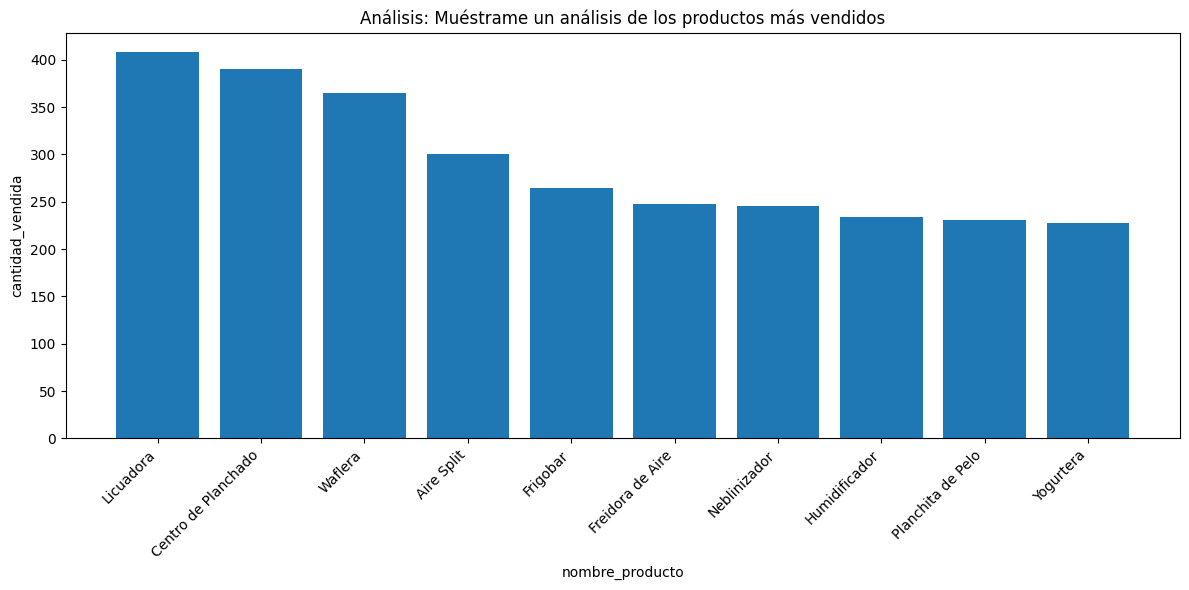


=== Proceso ReAct ===

Thought: Analizo la consulta "Muéstrame un análisis de los productos más vendidos".
Detecto que requiere información de tipo 'analytics'.

Action: Voy a usar la herramienta 'analytics' para obtener la información necesaria.

Observation:
Análisis completado. Gráfico guardado.

Datos:
       nombre_producto  cantidad_vendida
0            Licuadora               408
1  Centro de Planchado               390
2              Waflera               365
3           Aire Split               300
4             Frigobar               265
5     Freidora de Aire               248
6         Neblinizador               245
7        Humidificador               234
8    Planchita de Pelo               231
9            Yogurtera               228

Final Answer:
Análisis completado. Gráfico guardado.

Datos:
       nombre_producto  cantidad_vendida
0            Licuadora               408
1  Centro de Planchado               390
2              Waflera               365
3           Ai

In [117]:
consultas_prueba = [
    "¿Cómo uso mi licuadora para hacer smoothies?",
    "¿Cuáles son las licuadoras de menos de $500?",
    "¿Qué productos están en la categoría Cocina?",
    "Muéstrame un análisis de los productos más vendidos",
    "¿Qué marcas tienen productos de climatización?",
    "Necesito una cafetera económica con buen stock",
]

resultados_agente = []

for i, consulta in enumerate(consultas_prueba, 1):
    print(f"PRUEBA {i}/{len(consultas_prueba)}")
    print(f"Consulta: {consulta}\n")

    try:
        respuesta = agent.chat(consulta)
        print(respuesta)
        resultados_agente.append({
            'consulta': consulta,
            'respuesta': respuesta,
            'exito': True
        })

    except Exception as e:
        print(f"Error: {e}")
        resultados_agente.append({
            'consulta': consulta,
            'respuesta': str(e),
            'exito': False
        })

    print("\n")

print("RESUMEN DE PRUEBAS:")
exitosas = sum(1 for r in resultados_agente if r['exito'])
print(f"\nPruebas exitosas: {exitosas}/{len(consultas_prueba)}")

if exitosas == len(consultas_prueba):
    print("Todas las pruebas completadas exitosamente")
else:
    print(f"{len(consultas_prueba) - exitosas} pruebas fallaron")

### Pruebas del sistema de memoria

PRUEBAS CON MEMORIA CONVERSACIONAL

Ejecutando secuencia de consultas con memoria...

CONSULTA 1/4
Usuario: ¿Cuáles son las licuadoras de menos de $300?


=== Proceso ReAct ===

Thought: Analizo la consulta "¿Cuáles son las licuadoras de menos de $300?".
Detecto que requiere información de tipo 'tabular'.

Action: Voy a usar la herramienta 'table_search' para obtener la información necesaria.

Observation:
Error en búsqueda dinámica: (sqlite3.OperationalError) no such table: categorias
[SQL: SELECT nombre, precio_usd FROM productos WHERE categoria_

...

[Historial: 1 interacciones guardadas]

CONSULTA 2/4
Usuario: ¿Y cuáles tienen buen stock?


[Memoria activa] Detectada continuidad
  Tema anterior: licuadora
  Query original: '¿Y cuáles tienen buen stock?'
  Query enriquecida: 'licuadoras con buen stock'

=== Proceso ReAct ===

Thought: Analizo la consulta "licuadoras con buen stock".
Detecto que requiere información de tipo 'tabular'.

Action: Voy a usar la herramienta 'table_search

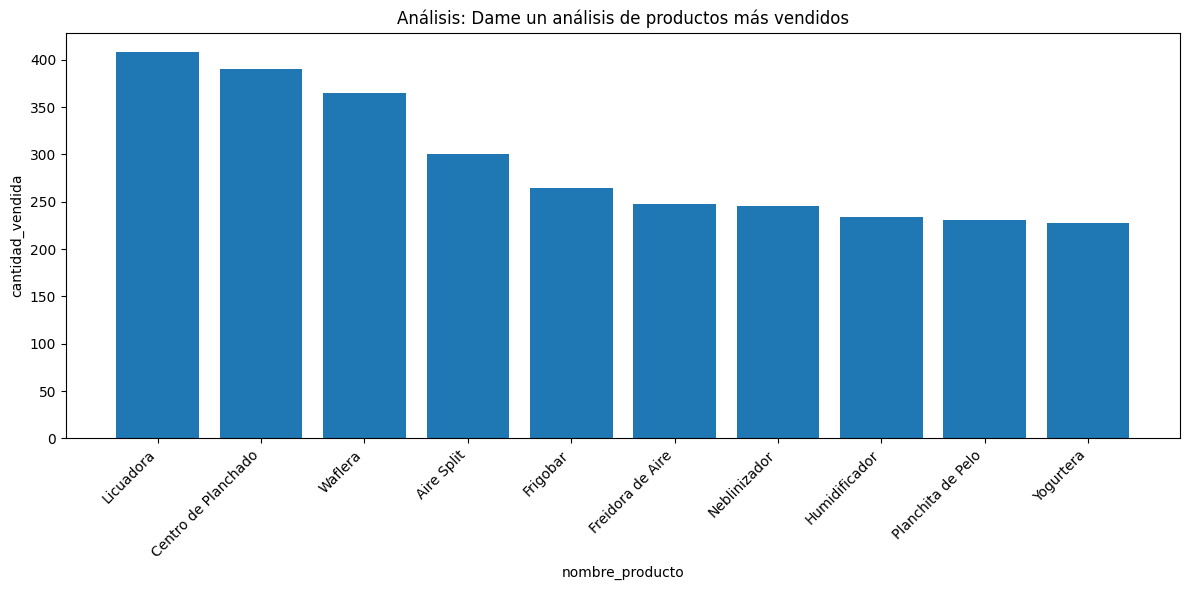


=== Proceso ReAct ===

Thought: Analizo la consulta "Dame un análisis de productos más vendidos".
Detecto que requiere información de tipo 'analytics'.

Action: Voy a usar la herramienta 'analytics' para obtener la información necesaria.

Observation:
Análisis completado. Gráfico guardado.

Datos:
       nombre_producto  cantidad_vendida
0            Licuadora               408
1  Centro de Planc

...

[Historial: 3 interacciones guardadas]

CONSULTA 4/4
Usuario: ¿Qué marcas tienen productos de climatización?

Cypher Dinámico: MATCH (p:Producto)-[:PERTENECE_A]->(c:Categoria {name: "Climatización"})
MATCH (p)-[:ES_DE_MARCA]->(m:Marca)
RETURN DISTINCT m.name

=== Proceso ReAct ===

Thought: Analizo la consulta "¿Qué marcas tienen productos de climatización?".
Detecto que requiere información de tipo 'grafos'.

Action: Voy a usar la herramienta 'graph_search' para obtener la información necesaria.

Observation:
Encontradas 5 relaciones:
AirFlow
PureAir
ThermoControl
ClimaTech
EcoClima

F

In [118]:
print("PRUEBAS CON MEMORIA CONVERSACIONAL")

#Secuencia de consultas que demuestran memoria
consultas_memoria = [
    "¿Cuáles son las licuadoras de menos de $300?",
    "¿Y cuáles tienen buen stock?",
    "Dame un análisis de productos más vendidos",
    "¿Qué marcas tienen productos de climatización?",
]

print("\nEjecutando secuencia de consultas con memoria...\n")

for i, consulta in enumerate(consultas_memoria, 1):
    print("="*70)
    print(f"CONSULTA {i}/{len(consultas_memoria)}")
    print("="*70)
    print(f"Usuario: {consulta}\n")

    respuesta = conversational_agent.chat(consulta)
    print(respuesta[:400])
    print("\n...")
    print(f"\n[Historial: {len(conversational_agent.history)} interacciones guardadas]\n")

#Historial
print("HISTORIAL COMPLETO DE LA CONVERSACIÓN")
print(conversational_agent.show_history())

### Prueba búsqueda tabular dinámica

In [119]:
result1 = table_search_tool_func("productos de más de 200 dólares con stock mayor a 50")
print(result1)

result2 = table_search_tool_func("licuadoras ordenadas por precio")
print(result2)

Encontrados 206 resultados:
• Licuadora - $283.63 (Stock: 108)
• Licuadora - $1273.06 (Stock: 114)
• Plus Licuadora Pro - $329.07 (Stock: 97)
• Compacto Licuadora - $259.42 (Stock: 75)
• Licuadora - $2602.78 (Stock: 97)
• Licuadora - $2532.47 (Stock: 198)
• Ultra Licuadora - $1201.99 (Stock: 164)
• Procesadora - $1213.21 (Stock: 56)
• Deluxe Procesadora - $1169.67 (Stock: 152)
• Profesional Procesadora 2024 - $356.86 (Stock: 111)
Error en búsqueda dinámica: (sqlite3.OperationalError) no such table: categorias
[SQL: SELECT * FROM productos WHERE categoria_id = (SELECT id FROM categorias WHERE nombre = 'Licuadoras') ORDER BY precio_usd ASC]
(Background on this error at: https://sqlalche.me/e/20/e3q8)


### Prueba búsqueda en grafo dinámica

In [120]:
result3 = graph_search_tool_func("marcas que fabrican productos de cocina")
print(result3)

result4 = graph_search_tool_func("productos de la marca TechHome")
print(result4)

Cypher Dinámico: MATCH (p:Producto)-[:PERTENECE_A]->(c:Categoria {name: "Cocina"})
MATCH (p)-[:ES_DE_MARCA]->(m:Marca)
RETURN DISTINCT m.name
Encontradas 5 relaciones:
CookElite
TechHome
ChefMaster
KitchenPro
HomeChef
Cypher Dinámico: MATCH (p:Producto)-[:ES_DE_MARCA]->(m:Marca {name: "TechHome"})
RETURN p
Encontradas 30 relaciones:
<Node element_id='4:0992d6f5-f41f-4dbd-bae6-9bb55f163f92:156' labels=frozenset({'Entity', 'Producto'}) properties={'name': 'P0147'}>
<Node element_id='4:0992d6f5-f41f-4dbd-bae6-9bb55f163f92:146' labels=frozenset({'Entity', 'Producto'}) properties={'name': 'P0137'}>
<Node element_id='4:0992d6f5-f41f-4dbd-bae6-9bb55f163f92:142' labels=frozenset({'Entity', 'Producto'}) properties={'name': 'P0133'}>
<Node element_id='4:0992d6f5-f41f-4dbd-bae6-9bb55f163f92:124' labels=frozenset({'Entity', 'Producto'}) properties={'name': 'P0116'}>
<Node element_id='4:0992d6f5-f41f-4dbd-bae6-9bb55f163f92:120' labels=frozenset({'Entity', 'Producto'}) properties={'name': 'P0112'}>


### Test gráfico con analytics_tool_func

🔗 SQL: SELECT cliente_provincia, SUM(total) AS total_ventas FROM ventas GROUP BY cliente_provincia
📊 Gráfico: bar


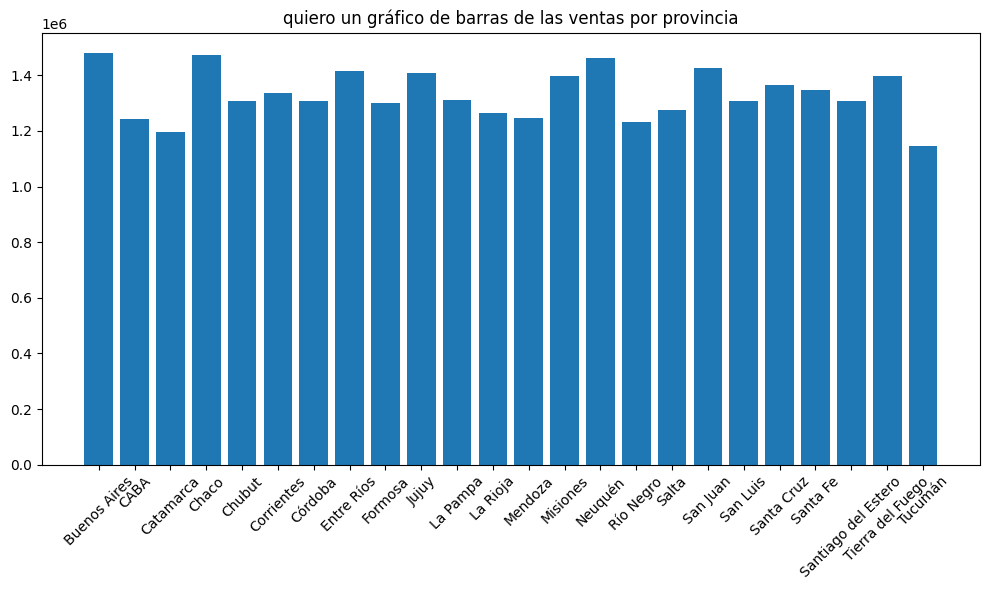

Gráfico generado.
      cliente_provincia  total_ventas
0          Buenos Aires    1479100.97
1                  CABA    1244332.38
2             Catamarca    1197654.56
3                 Chaco    1472982.80
4                Chubut    1308316.66
5            Corrientes    1335216.46
6               Córdoba    1307373.07
7            Entre Ríos    1414062.89
8               Formosa    1300130.41
9                 Jujuy    1408734.61
10             La Pampa    1313044.12
11             La Rioja    1265932.92
12              Mendoza    1245846.62
13             Misiones    1397566.41
14              Neuquén    1463820.89
15            Río Negro    1233923.82
16                Salta    1276621.78
17             San Juan    1424800.39
18             San Luis    1306725.58
19           Santa Cruz    1363938.92
20             Santa Fe    1346071.31
21  Santiago del Estero    1307061.76
22     Tierra del Fuego    1399177.99
23              Tucumán    1147836.61


In [126]:
result5 = analytics_tool_func("quiero un gráfico de barras de las ventas por provincia")
print(result5)